<a href="https://colab.research.google.com/github/rexian/ML/blob/main/pytorch/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sn
%matplotlib inline

In [ ]:
# Convert MNIST Image files into a tensor of 4-Dimentiones (# of Images, Height, Width, Color)
transform = transforms.ToTensor()


In [ ]:
# Train data
train_data = datasets.MNIST(root='/cnn_data', train=True, download=True, transform=transform)


Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 9912422/9912422 [00:00<00:00, 35369496.44it/s]


Extracting /cnn_data/MNIST/raw/train-images-idx3-ubyte.gz to /cnn_data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 28881/28881 [00:00<00:00, 1279584.38it/s]


Extracting /cnn_data/MNIST/raw/train-labels-idx1-ubyte.gz to /cnn_data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 1648877/1648877 [00:00<00:00, 8296633.78it/s]


Extracting /cnn_data/MNIST/raw/t10k-images-idx3-ubyte.gz to /cnn_data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 4542/4542 [00:00<00:00, 2516914.89it/s]

Extracting /cnn_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to /cnn_data/MNIST/raw



In [ ]:
# Test data
test_data = datasets.MNIST(root='/cnn_data', train=False, download=True, transform=transform)

In [ ]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: /cnn_data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [ ]:
# Create a small batch of images
batch_size = 10
train_data_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_data_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)


In [ ]:
# Define CNN Model
# Describe convolutional layer and what's they are doing
conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=3, stride=1, padding=0)
conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=3, stride=1, padding=0)


In [ ]:
# Grab 1 MNIST image / record
for i, (X_Train, y_train) in enumerate(train_data):
    break

X_Train.shape

torch.Size([1, 28, 28])

In [ ]:
x = X_Train.view(1,1,28,28)
x.shape
x = F.relu(conv1(x)) # Rectified Linear Unit for activation function
# 1 single image, 6 is the filter we set
x.shape

torch.Size([1, 6, 26, 26])

In [ ]:
# Pass through the pooling layer
x = F.max_pool2d(x, 2, 2) # kernal of 2 stride of 2
x.shape

torch.Size([1, 6, 13, 13])

In [ ]:
# Second convolutional layer
x = F.relu(conv2(x))
x.shape # we didn't set the padding, so we loose 2 pixles around the outside of image

torch.Size([1, 16, 11, 11])

In [ ]:
# Pooling layer
x = F.max_pool2d(x, 2, 2)
x.shape

torch.Size([1, 16, 5, 5])

In [ ]:
# Model class
class ConvolutionalNetwork(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size = 3, stride=1)
    self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size = 3, stride=1)
    # Fully connected layer
    self.fc1 = nn.Linear(in_features=5*5*16, out_features=120)
    self.fc2 = nn.Linear(in_features=120, out_features=84)
    self.fc3 = nn.Linear(in_features=84, out_features=10)

  def forward(self, x):
    # Convolutional layer 1
    x = self.conv1(x)
    x = F.relu(x)
    x = F.max_pool2d(x, kernel_size=2, stride=2)
    # 2nd pass
    x = self.conv2(x)
    x = F.relu(x)
    x = F.max_pool2d(x, kernel_size=2, stride=2)

    # Re-view to flatten it out
    x = x.reshape(-1, 5*5*16) # -1 so we can vary the batch size

    # Fully Connected Layers
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)

    return F.log_softmax(x, dim=1)



In [ ]:
# Create an Instance of the model
torch.manual_seed(41)
model = ConvolutionalNetwork()
model


ConvolutionalNetwork(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [ ]:
# Loss Function Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # Smaller the learning rate, longer it's gonna take to train

In [ ]:
import time
start_time = time.time()

# Create variables to track things
epochs = 5
train_losses = []
test_losses = []
train_correct = []
test_correct = []


# For loop for Epochs
for i in range(epochs):
  trn_corr = 0
  tst_corr = 0

  # Train
  for b, (X_train, y_train) in enumerate(train_data_loader):
    b+=1 # Start the batches at 1
    y_pred = model(X_train) # Get predicted values from the training set, not flattened
    loss = criterion(y_pred, y_train) # Calculate the loss, compare prediction with correct value

    predicted = torch.max(y_pred.data, 1)[1] # Add up the number of correct predictions
    batch_corr = (predicted == y_train).sum()
    trn_corr += batch_corr # Keep track as we go along training

    # Update parameters
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Print out some results
    if b%600 == 0:
      print(f'Epoch: {i}, Batch: {b}, Loss: {loss.item()}')

  train_losses.append(loss)
  train_correct.append(trn_corr)


  # Test
  with torch.no_grad(): # No gradient so we don't update weights and biases with tests
    for b, (X_test, y_test) in enumerate(test_data_loader):
      y_val = model(X_test)
      predicted = torch.max(y_val.data, 1)[1]
      tst_corr += (predicted == y_test).sum()

  loss = criterion(y_val, y_test)
  test_losses.append(loss)
  test_correct.append(tst_corr)


current_time = time.time()
total_time = current_time - start_time
print(f'Total Training Time: {total_time/60} minute.')





Epoch: 0, Batch: 600, Loss: 0.0
Epoch: 0, Batch: 1200, Loss: 0.0
Epoch: 0, Batch: 1800, Loss: 0.0
Epoch: 0, Batch: 2400, Loss: 0.0
Epoch: 0, Batch: 3000, Loss: 6.556489324793802e-07
Epoch: 0, Batch: 3600, Loss: 0.0
Epoch: 0, Batch: 4200, Loss: 0.0
Epoch: 0, Batch: 4800, Loss: 0.0002387770509812981
Epoch: 0, Batch: 5400, Loss: 3.218645474589721e-07
Epoch: 0, Batch: 6000, Loss: 1.5973917015799088e-06
Epoch: 1, Batch: 600, Loss: 0.0
Epoch: 1, Batch: 1200, Loss: 0.0015780450776219368
Epoch: 1, Batch: 1800, Loss: 0.31316858530044556
Epoch: 1, Batch: 2400, Loss: 0.0
Epoch: 1, Batch: 3000, Loss: 0.0
Epoch: 1, Batch: 3600, Loss: 0.0
Epoch: 1, Batch: 4200, Loss: 1.192092824453539e-08
Epoch: 1, Batch: 4800, Loss: 4.76837058727142e-08
Epoch: 1, Batch: 5400, Loss: 4.529850230028387e-06
Epoch: 1, Batch: 6000, Loss: 7.831367111066356e-05
Epoch: 2, Batch: 600, Loss: 0.0
Epoch: 2, Batch: 1200, Loss: 0.0
Epoch: 2, Batch: 1800, Loss: 4.76837058727142e-08
Epoch: 2, Batch: 2400, Loss: 0.0
Epoch: 2, Batch:

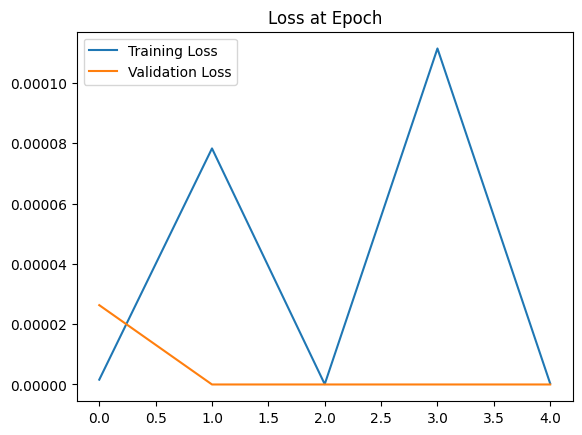

In [ ]:
# Graph the loss at each epoch
train_losses = [t.item() for t in train_losses]
#test_losses = [t.item() for t in test_losses]
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Validation Loss')
plt.title('Loss at Epoch')
plt.legend()

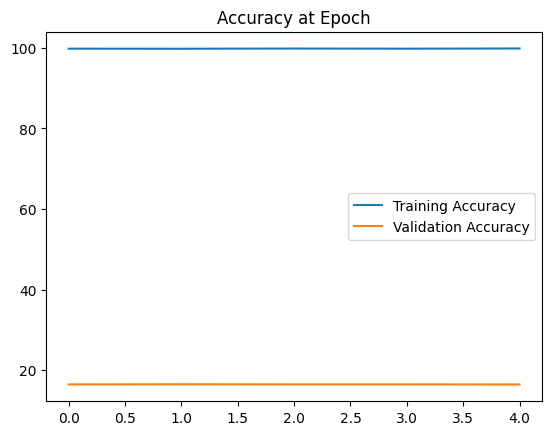

In [ ]:
# Graph the accuracy at the end of each epoch
plt.plot([t.item()/600 for t in train_correct], label='Training Accuracy')
plt.plot([t.item()/600 for t in test_correct], label='Validation Accuracy')
plt.title('Accuracy at Epoch')
plt.legend()

In [ ]:
# Accuracy
test_load_everything = DataLoader(test_data, batch_size=10000, shuffle=False)
with torch.no_grad():
  correct = 0
  for X_test, y_test in test_load_everything:
    y_val = model(X_test)
    predicted = torch.max(y_val.data, 1)[1]
    correct += (predicted == y_test).sum()
correct.item()/len(test_data) * 100

98.79

In [ ]:
# Grab an image
test_data[4243] # Tensor with an image in it, at the end it shows a label

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0980, 0.7882, 0.9922, 

In [ ]:
# Grab just the data
test_data[4243][0]

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0980, 0.7882, 0.9922, 0.8196, 0.1216,

In [ ]:
# Reshape it
test_data[4243][0].reshape(28,28)

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0980,
         0.7882, 0.9922, 0.8196, 0.1216, 0.0000, 0.0000

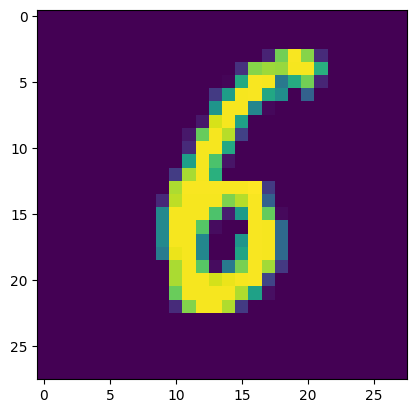

In [ ]:
# Display the image
plt.imshow(test_data[4243][0].reshape(28,28))

In [ ]:
# Pass the image through the model
model.eval()
with torch.no_grad():
  test_X = test_data[4243][0].view(1,1,28,28) # Batch size of 1
  prediction = model(test_X)
prediction

tensor([[ -61.9857,  -88.1522,  -85.6401,  -88.9251,  -60.5064,  -51.6371,
            0.0000, -120.1030,  -77.0473,  -86.0410]])

In [ ]:
prediction.argmax()

tensor(6)

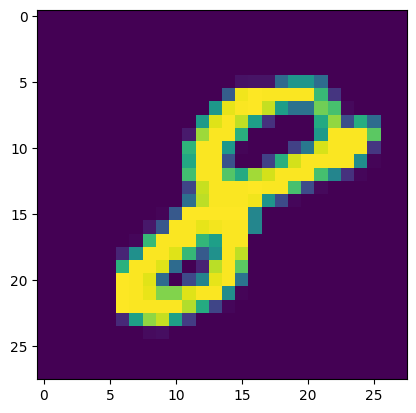

In [ ]:
# Display a number
plt.imshow(test_data[9563][0].reshape(28,28))

In [ ]:
model.eval()
with torch.no_grad():
  test_X = test_data[9563][0].view(1,1,28,28) # Batch size of 1
  prediction = model(test_X)
prediction

tensor([[ -86.1250, -102.8214,  -80.8663,  -89.9865, -103.0511,  -93.9722,
         -112.1227,  -87.5042,    0.0000,  -84.3243]])

In [ ]:
prediction.argmax()

tensor(8)